<a href="https://colab.research.google.com/github/gwohlgen/nlp4is_2020/blob/master/Spam_Detection_with_lesson3_imdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spam detection (based on fastai IMDB example)

1.   Inspired by [fastAI IMDB classifcation notebook](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-imdb.ipynb)
2.   The data is about email **spam detection** -- the classes are "spam" and "ham"
3.   Steps we take: (a) download and understand the data, (b) finetune the language model (LM), (c) train the classifier, (d) Evaluate the classifier



In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.text import *

## (a) Downloading and Understanding / EDA of the data
1. The data is encoded in latin-1, we want to change it to utf-8
2. Get some statistics of the data
3. Visualize length of the text and its distribution

In [0]:
!wget https://raw.githubusercontent.com/gwohlgen/misc/master/spam.csv
!ls

--2020-04-25 08:44:29--  https://raw.githubusercontent.com/gwohlgen/misc/master/spam.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/plain]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  --.-KB/s    in 0.05s   

2020-04-25 08:44:29 (10.2 MB/s) - ‘spam.csv’ saved [503663/503663]

sample_data  spam.csv


In [0]:
## change file encoding from latin-1 to utf-8

import codecs
infile  = codecs.open('spam.csv', 'r', encoding='latin1')
outfile = codecs.open('spam-utf8.csv', 'w', encoding='utf-8')

list(map(outfile.write, infile))

infile.close()
outfile.close()
!head spam-utf8.csv

# ok, data in utf-8 format now


v1,v2,,,
ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",,,
ham,Ok lar... Joking wif u oni...,,,
spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,,,
ham,U dun say so early hor... U c already then say...,,,
ham,"Nah I don't think he goes to usf, he lives around here though",,,
spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv",,,
ham,Even my brother is not like to speak with me. They treat me like aids patent.,,,
ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune,,,
spam,WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Clai

In [0]:
df = pd.read_csv('spam-utf8.csv')
df.head(10)


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


Hmm, why do we have 5 columns, maybe there is a mistake?


In [0]:
df.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""",GE,"GNT:-)"""
freq,4825,30,3,2,2


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


There are 50 / 12 / 6 rows in the unnamed columns, probably a mistake in terms of input separators. All text should be in the second (v2) column, **we have to fix this**!


In [0]:
# show part of df where "Unnamed: 2" column has some text -- we want to merge all that into the "real" text column
df[df["Unnamed: 2"].notna()]
 

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
95,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
281,ham,\Wen u miss someone,the person is definitely special for u..... B...,why to miss them,"just Keep-in-touch\"" gdeve.."""
444,ham,\HEY HEY WERETHE MONKEESPEOPLE SAY WE MONKEYAR...,HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE ...,NaN,NaN
671,spam,SMS. ac sun0819 posts HELLO:\You seem cool,"wanted to say hi. HI!!!\"" Stop? Send STOP to ...",NaN,NaN
710,ham,Height of Confidence: All the Aeronautics prof...,"this wont even start........ Datz confidence..""",NaN,NaN
899,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
1038,ham,"Edison has rightly said, \A fool can ask more ...",GN,GE,"GNT:-)"""
1127,ham,"Height of \Oh shit....!!\"" situation: A guy th...",".;-):-D""",NaN,NaN
1266,ham,\Hey sorry I didntgive ya a a bellearlier hunny,just been in bedbut mite go 2 thepub l8tr if u...,NaN,NaN
1384,ham,"Storming msg: Wen u lift d phne, u say \HELLO\...","bt not his girlfrnd... G o o d n i g h t . . .@""",NaN,NaN


In [0]:
# ok, we want to concat everything into the text column
# rename columns to something nicer
df.columns = ['label','text_orig','e1', 'e2','e3']


In [0]:
# let's try some ways to merge e1,e2,e3 into 'text'

# does this work? No, because of NaN
df['text'] = df['text_orig'] + df['e1'] + df['e2'] + df['e3']
print(df['text'].head())
print('\n\n')


# does this work? No, "nannannan" appended to the end
df['text'] = df['text_orig'] + df['e1'].astype(str) + df['e2'].astype(str) + df['e3'].astype(str)
print(df.head())
print(df.iloc[0,5])
print('\n\n')

# this is a solution -- na_rep is important in our case!
df["text"] = df["text_orig"].str.cat(df[['e1','e2','e3']], sep =" ", na_rep='')

# test on a few examples
print(df.iloc[0,5])   # e1, e2, e3 == NaN
print(df.iloc[95,5])  # e3 = NaN
print(df.iloc[281,5]) # all e1-e3 have text in them
print('\n\n')

# save the result into df_clean
df_clean = df[["label", "text"]]
df_clean.head()

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: text, dtype: object



  label  ...                                               text
0   ham  ...  Go until jurong point, crazy.. Available only ...
1   ham  ...             Ok lar... Joking wif u oni...nannannan
2  spam  ...  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  ...  U dun say so early hor... U c already then say...
4   ham  ...  Nah I don't think he goes to usf, he lives aro...

[5 rows x 6 columns]
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...nannannan



Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...   
Your free ringtone is waiting to be collected. Simply text the password \MIX\" to 85069 to verify. Get Usher and Britney. FML  PO Box 5249  MK17 92H. 450Ppw 16" 
\Wen u miss someone  the person is definitely special for u..... But if the person is so special  why to miss them  jus

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [0]:
df_clean.describe()

,label,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


Ok, we have some **text duplicates** (5169 unique out of 5572), that's not too great, **let's remove them**


In [0]:
df_final = df_clean.drop_duplicates(subset="text", keep = 'first', inplace = False)
df_final.describe()

,label,text
count,5169,5169
unique,2,5169
top,ham,Then get some cash together and I'll text jaso...
freq,4516,1


In [0]:
df_final.to_csv('spam_final.csv')
!head spam_final.csv


,label,text
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...   "
1,ham,Ok lar... Joking wif u oni...   
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's   
3,ham,U dun say so early hor... U c already then say...   
4,ham,"Nah I don't think he goes to usf, he lives around here though   "
5,spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv   "
6,ham,Even my brother is not like to speak with me. They treat me like aids patent.   
7,ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune   
8,spam,WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim c

**Dataset cleanup finished .. this is often one of the most time-intense steps**

Let's continue with some more EDA



In [0]:
text_length = df_final['text'].str.len()
text_length.describe()

count    5169.000000
mean       82.527762
std        58.467143
min         5.000000
25%        39.000000
50%        64.000000
75%       122.000000
max       913.000000
Name: text, dtype: float64

text_lengh.describe() shows us, that the avg text lenght is only 82 chars, so we have rather **short texts** to classify, typically one or 2 sentences. 
Below we want to visualize text_length of our documents.

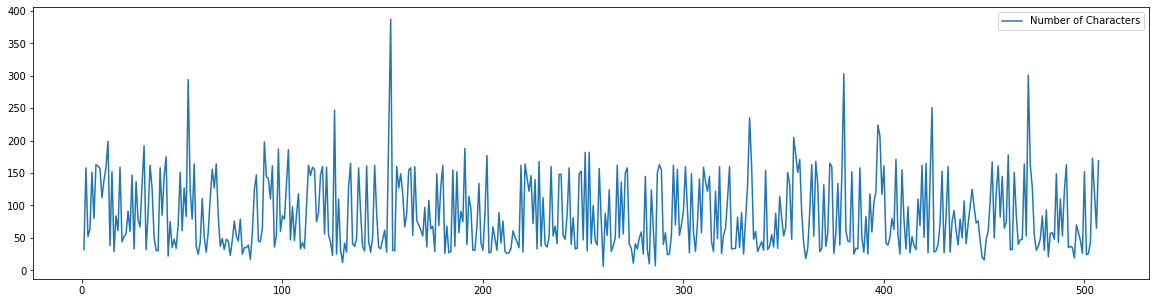

In [0]:
# plot length of first 500 texts
plt.figure()
text_length.iloc[1:500].plot(label='Number of Characters', figsize=(20, 5))
plt.legend(loc='best')

It's interesting that we have 2 peaks, one peak with documents around 35 chars long, and one around 150 chars  


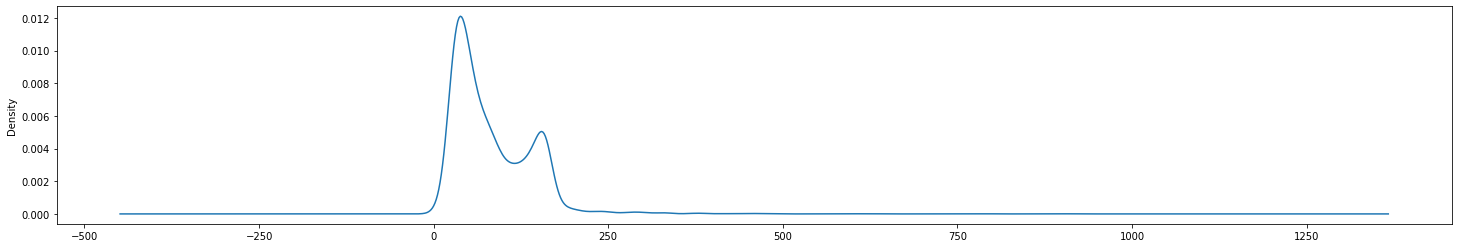

In [0]:
# density plot
text_length.plot(kind='kde', figsize=(25,4))
print("It's interesting that we have 2 peaks, one peak with documents around 35 chars long, and one around 150 chars  ")


## (b) Language model fine-tuning

*Note* that language models can use a lot of GPU, so you may need to decrease batchsize here.


In [0]:
bs=48

Now let's grab the full dataset for what follows.

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data-lm object with the data block API (next line may take a few minutes).

In [0]:
data_lm = (TextList.from_csv('.', 'spam_final.csv', cols='text')
                .split_by_rand_pct(0.1, seed=42) # split into train and val (90/10%)
                .label_for_lm() # train LM as a self-supervised task
                .databunch())

# save and load -- relevant if we have large models that take a long time to compute
data_lm.save('data_lm.pkl')

In [0]:
data_lm = load_data(".", 'data_lm.pkl', bs=bs)

In [0]:
data_lm.show_batch()

idx,text
0,"xxunk txt xxunk 's apply xxunk 's xxbos u dun say so early xxunk ... u c already then say ... xxbos xxmaj nah i do n't think he goes to usf , he lives around here though xxbos freemsg xxmaj hey there darling it 's been 3 week 's now and no word back ! i 'd like some fun you up for it still ? xxmaj tb ok"
1,"my xxunk page it still says boston . xxbos xxmaj umma my life and vava umma love you lot dear xxbos xxmaj thanks a lot for your xxunk on my birthday . xxmaj thanks you for making my birthday truly xxunk . xxbos xxmaj aight , i 'll hit you up when i get some cash xxbos i know ! xxmaj xxunk old people . xxmaj my mom was like"
2,"> or xxunk the bill xxbos xxmaj both :) i shoot big loads so get ready ! xxbos xxmaj what 's up xxunk , hope you had a great break . xxmaj do have a xxunk semester . xxbos xxmaj home so we can always chat xxbos xxmaj xxunk well . xxbos xxmaj yup ... xxmaj how ì _ noe leh ... xxbos xxmaj sounds great ! xxmaj are you"
3,& i m still waitin 4 1 . xxmaj pete x xxbos xxmaj that would be great . xxmaj we 'll be at the xxmaj xxunk . xxmaj could meet on xxmaj xxunk road or somewhere - will get in touch over weekend . xxmaj our plans take xxunk ! xxmaj have a good week xxbos xxmaj no problem . xxmaj how are you doing ? xxbos xxmaj hi xxunk
4,"ldn xxup wc1n3xx xxbos xxmaj you available now ? i 'm like right around xxunk & & < # > th xxbos xxmaj the message sent is askin for < # > dollars . xxmaj xxunk i pay < # > or < # > ? xxbos xxmaj how long does xxunk fucking take xxbos xxmaj hi hope u get this txt xxunk journey has nt been gd , now"


As we see in `data_lm.show_batch()`, fastAI did some text preprocessing, for example lowercasing, splitting into tokens, replacing rare tokens with `xxunk`, etc.

In [0]:
# create a LM learner based on the pretrained AWD_LSTM (trained on Wikitext-103)
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


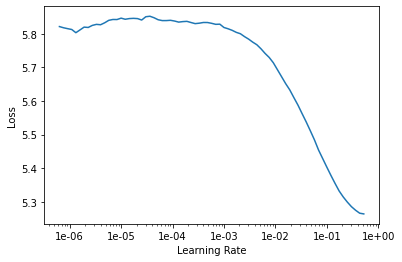

In [0]:
# find suitable learning rate
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [0]:
learn.fit_one_cycle(2, 5e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.637009,3.931929,0.272321,00:03
1,3.993435,3.721095,0.297024,00:03


In [0]:
learn.save('fit_head')

In [0]:
learn.load('fit_head');

To complete the fine-tuning, we can then unfeeze all layers and launch a new training.

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


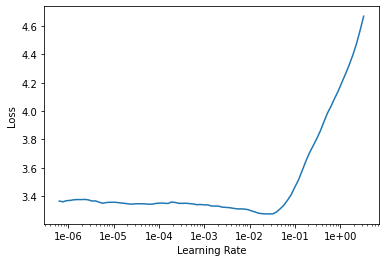

In [0]:
learn.lr_find()
learn.recorder.plot()


In [0]:
learn.fit_one_cycle(5, 3e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.296569,3.637670,0.311905,00:03
1,3.173525,3.560798,0.327827,00:03
2,2.896926,3.577863,0.331101,00:03
3,2.560524,3.651957,0.335640,00:03
4,2.243478,3.727463,0.335938,00:03


In [0]:
learn.save('fine_tuned')

Ok, the model predicts the next word correctly in 33.5% of cases, that's nice.

How good is our model? Well let's try to see what it predicts after a few given words.

In [0]:
learn.load('fine_tuned');

In [0]:
TEXT = "Buy some"
N_WORDS = 40
N_SENTENCES = 2

In [0]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Buy some food . You would have to send them a note that says we could meet at some point before < TIME > . xxbos Alex says he 'll be in the same boat . When he
Buy some food mum called buy for ? Buy one egg for me later . Call me xxbos Went fast asleep care .. xxbos Wat time are ur doing ? xxbos That 's The Car


We have to save not only the model, but also its encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [0]:
learn.save_encoder('fine_tuned_enc')

## (c) Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [0]:
# when creating the classifier databunch, it's important to use the same vocab as in the LM
# that's why we need "vocab=data_lm.vocab"

data_clas = (TextList.from_csv('.', 'spam_final.csv', cols='text', vocab=data_lm.vocab)
                .split_by_rand_pct(0.2, seed=42) # train/val splitting
                .label_from_df(cols=1) # label with column 1 ('label')
                .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [0]:
data_clas = load_data(".", 'data_clas.pkl', bs=bs)

In [0]:
data_clas.show_batch()
# we can see that we now have the text, and the target (labels) .. looks fine!

text,target
"xxbos xxmaj the last thing i ever wanted to do was hurt you . xxmaj and i did n't think it would have . xxmaj you 'd laugh , be embarassed , xxunk the xxunk and keep going . xxmaj but as far as i knew , it was n't even up . xxmaj the fact that you even felt like i would do it to hurt you shows you",ham
"xxbos xxmaj sad story of a xxmaj man - xxmaj last week was my b'day . xxmaj my xxmaj wife xxunk wish me . xxmaj my xxmaj parents forgot n so did my xxmaj kids . i went to work . xxmaj even my xxmaj colleagues did not wish . xxmaj as i entered my xxunk my xxup pa said , '' xxmaj happy xxmaj b'day xxmaj boss ! !",ham
xxbos xxmaj for me the love should start with xxunk should feel that i need her every time around xxunk should be the first thing which comes in my xxunk . i would start the day and end it with xxunk should be there every time i xxunk will be then when my every xxunk has her xxunk life should happen around xxunk life will be xxunk to her .,ham
xxbos xxmaj how to xxmaj make a girl xxmaj happy ? xxmaj it 's not at all difficult to make girls happy . u only need to be ... 1 . a friend 2 . xxmaj xxunk 3 . xxmaj lover 4 . xxmaj xxunk . . . < # > . xxmaj good xxunk < # > . xxmaj xxunk < # > . xxmaj good xxunk < #,ham
"xxbos xxmaj indians r poor but xxmaj india is not a poor country . xxmaj says one of the xxunk bank xxunk . xxmaj he says that \ < # > xxunk xxunk "" of xxmaj indian money is xxunk in xxunk banks which can be used for ' xxunk ' budget for < # > yrs . xxmaj can give < # > xxunk xxunk to all xxmaj indians",ham


We can then create a model to classify those reviews and load the encoder we saved before.

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc') # load our fine-tuned LM encoder!

RNNLearner(data=TextClasDataBunch;

Train: LabelList (4136 items)
x: TextList
xxbos xxmaj go until xxunk point , crazy .. xxmaj available only in bugis n great world la e xxunk ... xxmaj cine there got xxunk wat ...,xxbos xxmaj ok lar ... xxmaj joking wif u oni ...,xxbos xxmaj free entry in 2 a wkly comp to win xxup xxunk xxmaj cup final xxunk xxunk xxmaj may xxunk . xxmaj text xxup xxunk to xxunk to receive entry xxunk txt xxunk 's apply xxunk 's,xxbos u dun say so early xxunk ... u c already then say ...,xxbos xxmaj nah i do n't think he goes to usf , he lives around here though
y: CategoryList
ham,ham,spam,ham,ham
Path: .;

Valid: LabelList (1033 items)
x: TextList
xxbos xxmaj did u download the xxunk app ?,xxbos xxmaj pass dis to all ur xxunk n see wat u get ! xxmaj xxunk in luv wid u. xxmaj xxunk put a smile on my face . xxmaj xxunk r realy hot . xxmaj xxunk r so swt . xxmaj xxunk thnk i xxunk u. xxmaj xxunk realy wana go out wid u. xxmaj xxunk xxunk u xxunk . xxmaj xxunk xxunk of

Look at the output above, we can see the train/val split, the model used (with the encoder and then the classifier, and other things like the loss_function)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


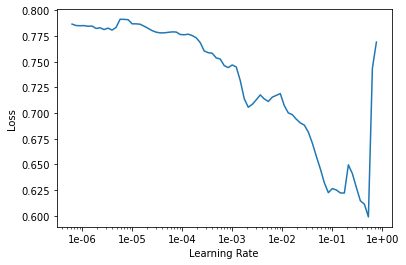

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(2, 4e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.256673,0.097852,0.972894,00:04
1,0.138447,0.043804,0.984511,00:04


In [0]:
learn.save('first')

In [0]:
learn.load('first');

After only a bit of training on the freezed model, we already have 98% accuracy. This is a rather simple problem :)
Let's try to improve the accuracy even more!

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


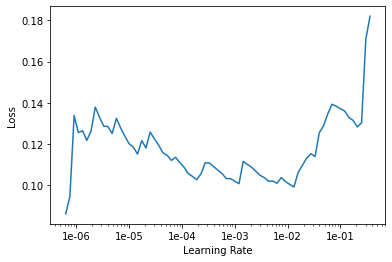

In [0]:
learn.freeze_to(-2)

learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, slice(2e-3/(2.6**4),2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.087103,0.040443,0.988383,00:03


In [0]:
learn.save('second')

In [0]:
learn.load('second');

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


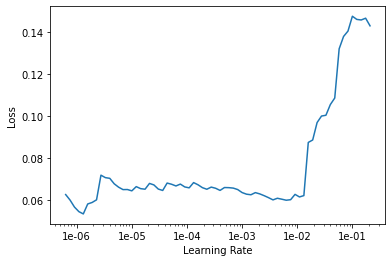

In [0]:
learn.freeze_to(-3)

learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.071875,0.039100,0.983543,00:04


In [0]:
learn.save('third')

In [0]:
learn.load('third');

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


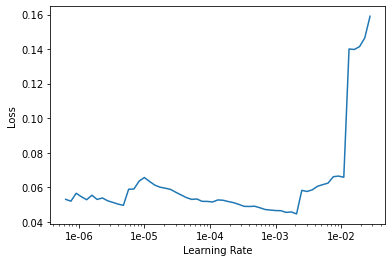

In [0]:
learn.unfreeze()

learn.lr_find()
learn.recorder.plot()

In [0]:

learn.fit_one_cycle(5, slice(5e-4/(2.6**4),5e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.052509,0.033269,0.988383,00:04
1,0.051116,0.029535,0.990319,00:04
2,0.041809,0.030234,0.990319,00:04
3,0.036781,0.029103,0.992256,00:04
4,0.031459,0.029175,0.991288,00:04


Ok, we are finished training. We are now at 99.1% accuracy. The train_loss is still above valid_loss, so we could definitly train some more!

# (d) Evaluation of the model
Looks have a brief look at things like the confusion matrix, and prediction example and prediction time


Let's predict some examples just for testing:


In [0]:
learn.predict("Free entry in 2 a wkly comp to win FA Cup final.")
# class 0 is ham, class 1 is spam. prediction looks fine

(Category spam, tensor(1), tensor([0.0015, 0.9985]))

In [0]:
%%timeit
learn.predict("Free entry in 2 a wkly comp to win FA Cup final.")


10 loops, best of 3: 145 ms per loop


In [0]:
learn.predict("Let's meet tomorrow and discuss the project.")

(Category ham, tensor(0), tensor([1.0000e+00, 2.1876e-06]))

Finally let's look at the confusion matrix

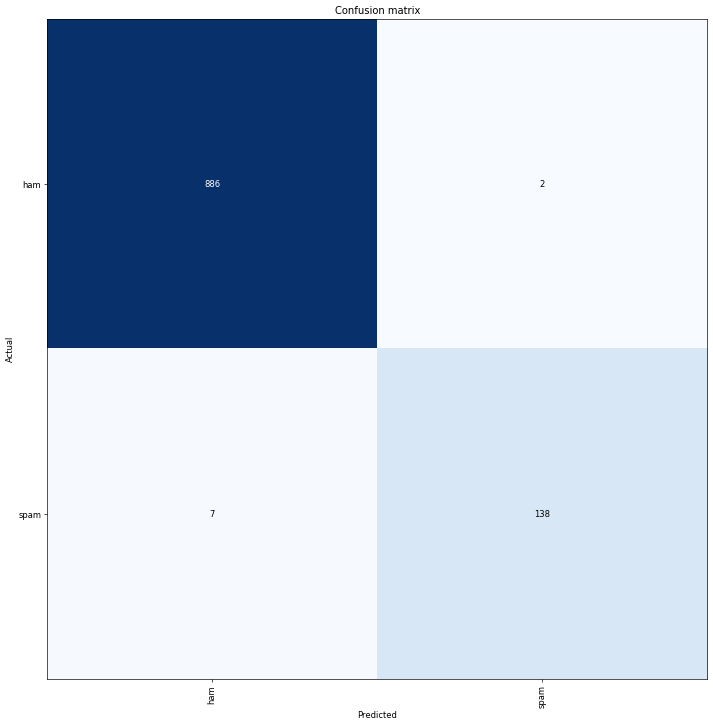

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
interp.most_confused(min_val=2)
# so the largest part of our validation error are docs that were classified as ham,
# although they should be spam

[('spam', 'ham', 7), ('ham', 'spam', 2)]

In [0]:
print(interp.top_losses())

torch.return_types.topk(
values=tensor([6.4405, 2.4401, 1.7176,  ..., -0.0000, -0.0000, -0.0000]),
indices=tensor([958, 549, 143,  ..., 410, 118, 641]))


We see that index 958 has the highest loss, let's have a look.

In [0]:
print(data_clas.valid_ds[958])

# call predict on the text of example 958. It should be classified as spam.
learn.predict(data_clas.valid_ds[958][0])

# but it's is classified as ham, with high certainty, that's why we have a high loss here.

(Text xxbos xxmaj did you hear about the new \ xxmaj xxunk xxmaj xxunk " ? xxmaj it comes with all of xxmaj xxunk 's stuff ! ", Category spam)


(Category ham, tensor(0), tensor([0.9988, 0.0012]))